Detailed explanation:
https://medium.com/@alexppppp/how-to-train-a-custom-keypoint-detection-model-with-pytorch-d9af90e111da

GitHub repo:
https://github.com/alexppppp/keypoint_rcnn_training_pytorch

# 1. Imports

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

In [2]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

In [3]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

# 3. Dataset class

In [4]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
#        print("img_path")
 #       print(img_path)
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
#        print("annotations_path")
        print(annotations_path)
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
#            print("data")
#            print(data)
            bboxes_original = data['bboxes']
#            print(bboxes_original)
            keypoints_original = data['keypoints']
 #           print(keypoints_original)
            # All objects are glue tubes
            bboxes_labels_original = ['Glue tube' for _ in bboxes_original]            
 #           print(bboxes_labels_original)
        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
#            print("keypoints_original_flattened")
#            print(keypoints_original_flattened)
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
#            print("transformed")
#            print(transformed)
            img = transformed['image']
#            print(img.shape)
            bboxes = transformed['bboxes']
#            print(bboxes)
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()
#            print("keypoints_transformed_unflattened")
#            print(keypoints_transformed_unflattened)
            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                print(o_idx, obj)
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    print(k_idx, kp)
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                    print("***************")
                    print(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32) 
#        print(bboxes)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
#        print(target["labels"])
        target["image_id"] = torch.tensor([idx])
#        print(target["image_id"])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
#        print(target["area"])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
#        print(target["iscrowd"])
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
#        print(target["keypoints"])
        img = F.to_tensor(img)
 #       print(img)
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset

In [5]:
KEYPOINTS_FOLDER_TRAIN = 'keypoint/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

keypoint/train/annotations/5.json
0 [[209, 547], [360, 516]]
0 [209, 547]
***************
[209, 547, 1]
1 [360, 516]
***************
[360, 516, 1]
1 [[213, 197], [347, 117]]
0 [213, 197]
***************
[213, 197, 1]
1 [347, 117]
***************
[347, 117, 1]
Original targets:
 ({'boxes': tensor([[ 60., 176., 160., 396.],
        [406., 180., 554., 382.]]), 'labels': tensor([1, 1]), 'image_id': tensor([19]), 'area': tensor([22000., 29896.]), 'iscrowd': tensor([0, 0]), 'keypoints': tensor([[[ 92., 209.,   1.],
         [123., 360.,   1.]],

        [[442., 213.,   1.],
         [522., 347.,   1.]]])},) 


Transformed targets:
 ({'boxes': tensor([[176., 480., 396., 580.],
        [180.,  86., 382., 234.]]), 'labels': tensor([1, 1]), 'image_id': tensor([19]), 'area': tensor([22000., 29896.]), 'iscrowd': tensor([0, 0]), 'keypoints': tensor([[[209., 547.,   1.],
         [360., 516.,   1.]],

        [[213., 197.,   1.],
         [347., 117.,   1.]]])},)


In [6]:
dataset.transform

Compose([
  Sequential([
    RandomRotate90(always_apply=False, p=1),
    RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), brightness_by_max=True),
  ], p=1),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['bboxes_labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params={'format': 'xy', 'label_fields': None, 'remove_invisible': True, 'angle_in_degrees': True, 'check_each_transform': True}, additional_targets={})

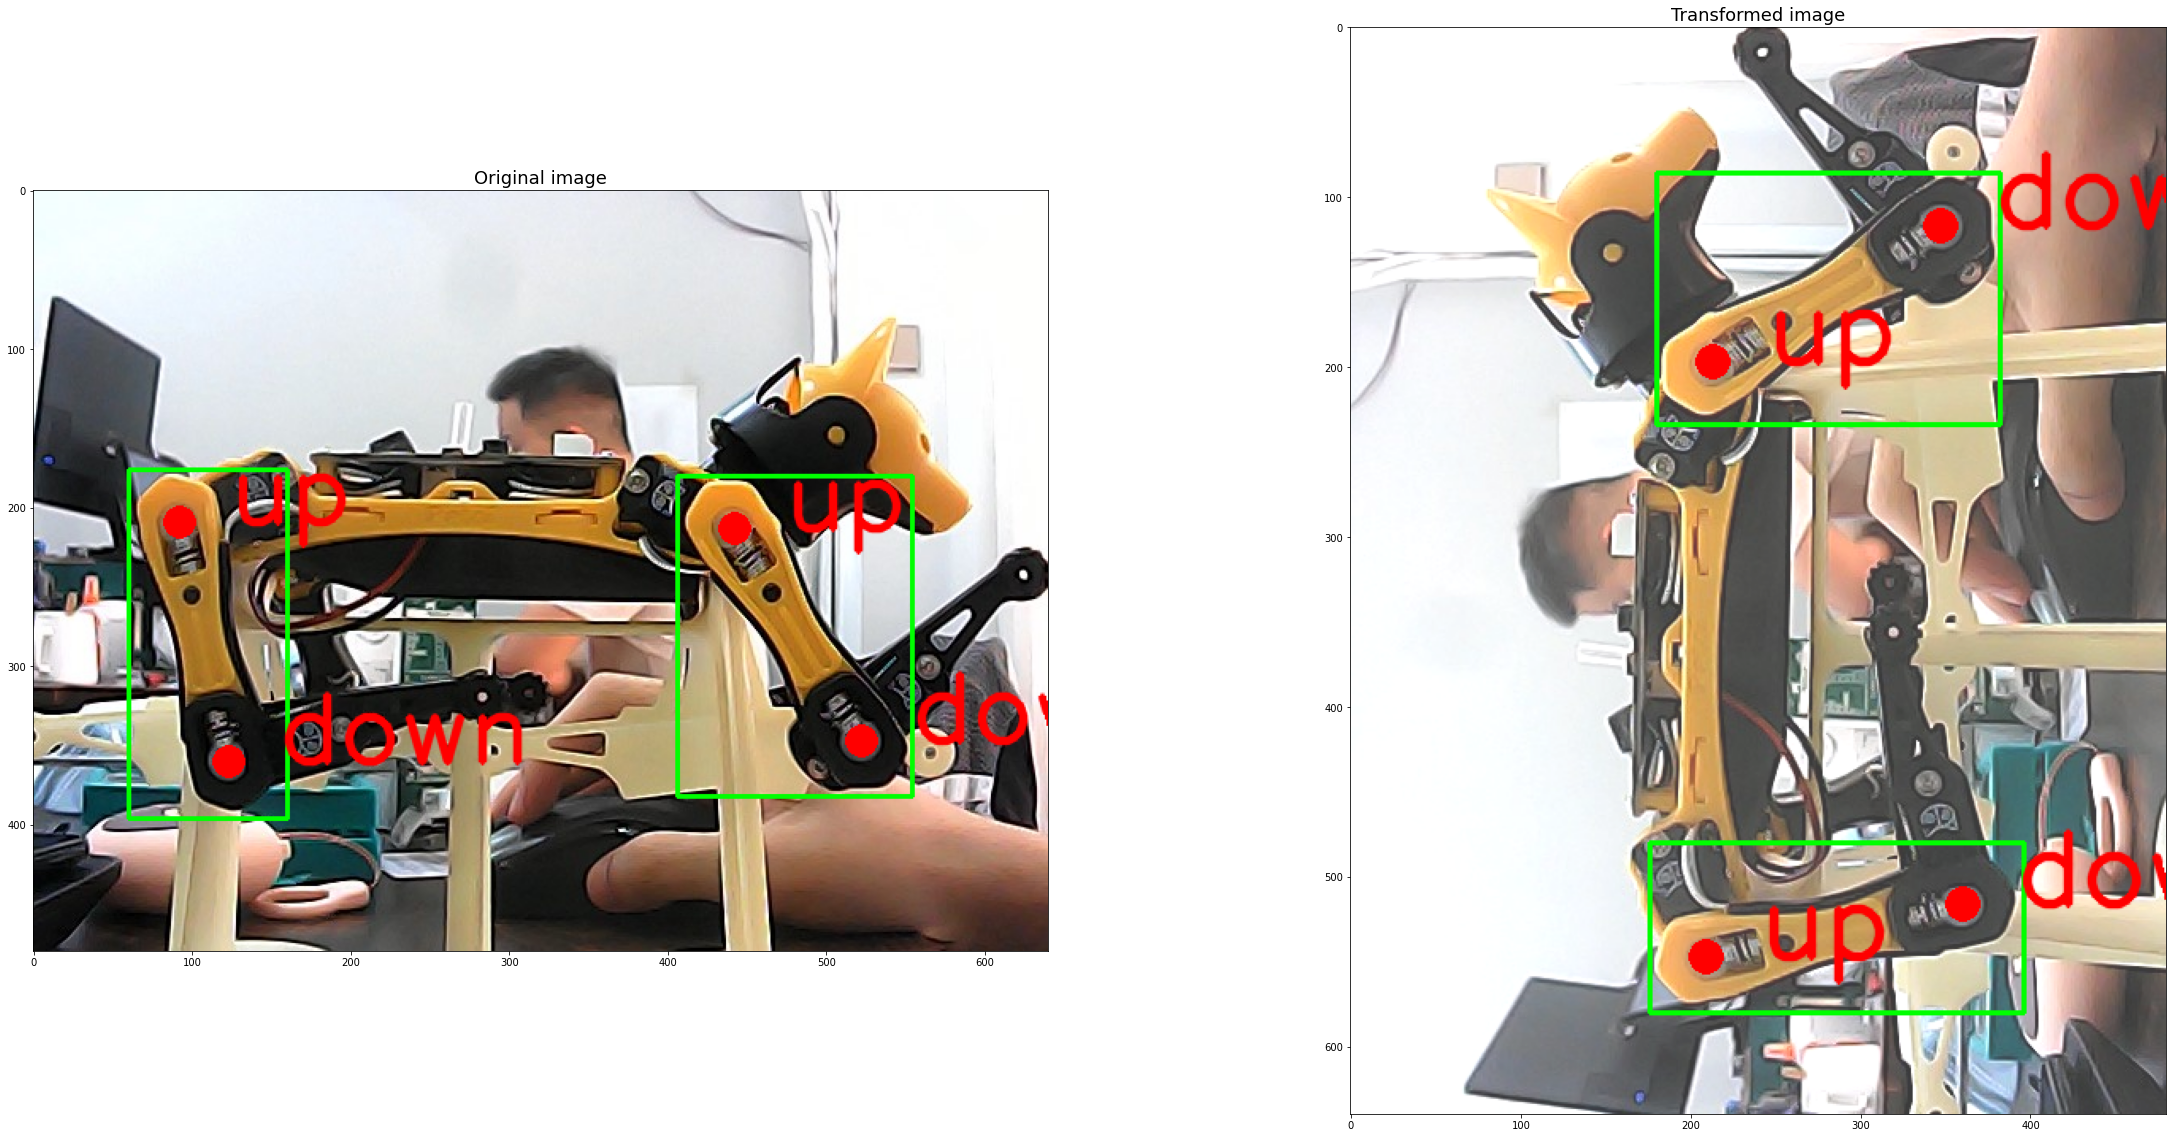

In [7]:
keypoints_classes_ids2names = {0: 'up', 1: 'down'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [8]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = 'keypoint/train'
KEYPOINTS_FOLDER_TEST = 'keypoint/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), 'keypointsrcnn_weights.pth')

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/root/miniconda3/envs/myconda/lib

keypoint/train/annotations/21.json
0 [[269, 92], [117, 76]]
0 [269, 92]
***************
[269, 92, 1]
1 [117, 76]
***************
[117, 76, 1]
1 [[266, 443], [117, 391]]
0 [266, 443]
***************
[266, 443, 1]
1 [117, 391]
***************
[117, 391, 1]
Epoch: [0]  [ 0/24]  eta: 0:00:39  lr: 0.000044  loss: 9.5140 (9.5140)  loss_classifier: 0.6366 (0.6366)  loss_box_reg: 0.0111 (0.0111)  loss_keypoint: 8.1624 (8.1624)  loss_objectness: 0.6913 (0.6913)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 1.6512  data: 0.0159  max mem: 1162
keypoint/train/annotations/13.json
0 [[91, 210], [122, 360]]
0 [91, 210]
***************
[91, 210, 1]
1 [122, 360]
***************
[122, 360, 1]
1 [[440, 213], [409, 366]]
0 [440, 213]
***************
[440, 213, 1]
1 [409, 366]
***************
[409, 366, 1]
keypoint/train/annotations/10.json
0 [[270, 92], [119, 121]]
0 [270, 92]
***************
[270, 92, 1]
1 [119, 121]
***************
[119, 121, 1]
1 [[265, 441], [110, 443]]
0 [265, 441]
***************
[265, 

Epoch: [1]  [ 0/24]  eta: 0:00:20  lr: 0.001000  loss: 8.4517 (8.4517)  loss_classifier: 0.0604 (0.0604)  loss_box_reg: 0.0267 (0.0267)  loss_keypoint: 7.7237 (7.7237)  loss_objectness: 0.6310 (0.6310)  loss_rpn_box_reg: 0.0099 (0.0099)  time: 0.8503  data: 0.0180  max mem: 1646
keypoint/train/annotations/20.json
0 [[269, 92], [116, 76]]
0 [269, 92]
***************
[269, 92, 1]
1 [116, 76]
***************
[116, 76, 1]
1 [[266, 444], [112, 469]]
0 [266, 444]
***************
[266, 444, 1]
1 [112, 469]
***************
[112, 469, 1]
keypoint/train/annotations/21.json
0 [[269, 92], [117, 76]]
0 [269, 92]
***************
[269, 92, 1]
1 [117, 76]
***************
[117, 76, 1]
1 [[266, 443], [117, 391]]
0 [266, 443]
***************
[266, 443, 1]
1 [117, 391]
***************
[117, 391, 1]
keypoint/train/annotations/22.json
0 [[547, 268], [563, 116]]
0 [547, 268]
***************
[547, 268, 1]
1 [563, 116]
***************
[563, 116, 1]
1 [[197, 266], [102, 140]]
0 [197, 266]
***************
[197, 

Epoch: [2]  [ 0/24]  eta: 0:00:23  lr: 0.001000  loss: 7.6661 (7.6661)  loss_classifier: 0.0792 (0.0792)  loss_box_reg: 0.0487 (0.0487)  loss_keypoint: 7.1142 (7.1142)  loss_objectness: 0.4155 (0.4155)  loss_rpn_box_reg: 0.0085 (0.0085)  time: 0.9953  data: 0.0172  max mem: 1646
keypoint/train/annotations/13.json
0 [[269, 91], [119, 122]]
0 [269, 91]
***************
[269, 91, 1]
1 [119, 122]
***************
[119, 122, 1]
1 [[266, 440], [113, 409]]
0 [266, 440]
***************
[266, 440, 1]
1 [113, 409]
***************
[113, 409, 1]
keypoint/train/annotations/3.json
0 [[92, 211], [78, 363]]
0 [92, 211]
***************
[92, 211, 1]
1 [78, 363]
***************
[78, 363, 1]
1 [[440, 213], [521, 348]]
0 [440, 213]
***************
[440, 213, 1]
1 [521, 348]
***************
[521, 348, 1]
keypoint/train/annotations/8.json
0 [[547, 270], [516, 119]]
0 [547, 270]
***************
[547, 270, 1]
1 [516, 119]
***************
[516, 119, 1]
1 [[198, 266], [244, 116]]
0 [198, 266]
***************
[198,

Epoch: [3]  [ 0/24]  eta: 0:00:20  lr: 0.001000  loss: 6.1273 (6.1273)  loss_classifier: 0.1776 (0.1776)  loss_box_reg: 0.1155 (0.1155)  loss_keypoint: 5.7425 (5.7425)  loss_objectness: 0.0775 (0.0775)  loss_rpn_box_reg: 0.0142 (0.0142)  time: 0.8560  data: 0.0190  max mem: 1646
keypoint/train/annotations/12.json
0 [[91, 210], [122, 359]]
0 [91, 210]
***************
[91, 210, 1]
1 [122, 359]
***************
[122, 359, 1]
1 [[442, 213], [413, 368]]
0 [442, 213]
***************
[442, 213, 1]
1 [413, 368]
***************
[413, 368, 1]
keypoint/train/annotations/14.json
0 [[91, 209], [122, 360]]
0 [91, 209]
***************
[91, 209, 1]
1 [122, 360]
***************
[122, 360, 1]
1 [[441, 214], [421, 369]]
0 [441, 214]
***************
[441, 214, 1]
1 [421, 369]
***************
[421, 369, 1]
keypoint/train/annotations/16.json
0 [[210, 548], [362, 526]]
0 [210, 548]
***************
[210, 548, 1]
1 [362, 526]
***************
[362, 526, 1]
1 [[213, 197], [366, 159]]
0 [213, 197]
***************


Epoch: [4]  [ 0/24]  eta: 0:00:22  lr: 0.001000  loss: 5.2142 (5.2142)  loss_classifier: 0.1745 (0.1745)  loss_box_reg: 0.1176 (0.1176)  loss_keypoint: 4.8489 (4.8489)  loss_objectness: 0.0610 (0.0610)  loss_rpn_box_reg: 0.0122 (0.0122)  time: 0.9203  data: 0.0151  max mem: 1646
keypoint/train/annotations/1.json
0 [[270, 91], [117, 78]]
0 [270, 91]
***************
[270, 91, 1]
1 [117, 78]
***************
[117, 78, 1]
1 [[267, 441], [111, 469]]
0 [267, 441]
***************
[267, 441, 1]
1 [111, 469]
***************
[111, 469, 1]
keypoint/train/annotations/11.json
0 [[269, 90], [119, 121]]
0 [269, 90]
***************
[269, 90, 1]
1 [119, 121]
***************
[119, 121, 1]
1 [[266, 442], [111, 464]]
0 [266, 442]
***************
[266, 442, 1]
1 [111, 464]
***************
[111, 464, 1]
keypoint/train/annotations/17.json
0 [[91, 208], [75, 362]]
0 [91, 208]
***************
[91, 208, 1]
1 [75, 362]
***************
[75, 362, 1]
1 [[442, 213], [480, 366]]
0 [442, 213]
***************
[442, 213,

Epoch: [5]  [ 0/24]  eta: 0:00:28  lr: 0.000300  loss: 3.5042 (3.5042)  loss_classifier: 0.0950 (0.0950)  loss_box_reg: 0.1223 (0.1223)  loss_keypoint: 3.2299 (3.2299)  loss_objectness: 0.0499 (0.0499)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 1.1720  data: 0.0182  max mem: 1646
keypoint/train/annotations/6.json
0 [[270, 92], [119, 123]]
0 [270, 92]
***************
[270, 92, 1]
1 [119, 123]
***************
[119, 123, 1]
1 [[266, 440], [108, 444]]
0 [266, 440]
***************
[266, 440, 1]
1 [108, 444]
***************
[108, 444, 1]
keypoint/train/annotations/24.json
0 [[548, 270], [582, 120]]
0 [548, 270]
***************
[548, 270, 1]
1 [582, 120]
***************
[582, 120, 1]
1 [[196, 266], [102, 140]]
0 [196, 266]
***************
[196, 266, 1]
1 [102, 140]
***************
[102, 140, 1]
keypoint/train/annotations/7.json
0 [[270, 92], [119, 123]]
0 [270, 92]
***************
[270, 92, 1]
1 [119, 123]
***************
[119, 123, 1]
1 [[266, 442], [116, 396]]
0 [266, 442]
***************
[2

Epoch: [6]  [ 0/24]  eta: 0:00:27  lr: 0.000300  loss: 3.1790 (3.1790)  loss_classifier: 0.0886 (0.0886)  loss_box_reg: 0.2106 (0.2106)  loss_keypoint: 2.8298 (2.8298)  loss_objectness: 0.0428 (0.0428)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 1.1263  data: 0.0156  max mem: 1646
keypoint/train/annotations/5.json
0 [[209, 547], [360, 516]]
0 [209, 547]
***************
[209, 547, 1]
1 [360, 516]
***************
[360, 516, 1]
1 [[213, 197], [347, 117]]
0 [213, 197]
***************
[213, 197, 1]
1 [347, 117]
***************
[347, 117, 1]
keypoint/train/annotations/6.json
0 [[547, 270], [516, 119]]
0 [547, 270]
***************
[547, 270, 1]
1 [516, 119]
***************
[516, 119, 1]
1 [[199, 266], [195, 108]]
0 [199, 266]
***************
[199, 266, 1]
1 [195, 108]
***************
[195, 108, 1]
keypoint/train/annotations/22.json
0 [[211, 547], [363, 563]]
0 [211, 547]
***************
[211, 547, 1]
1 [363, 563]
***************
[363, 563, 1]
1 [[213, 197], [339, 102]]
0 [213, 197]
************

Epoch: [7]  [ 0/24]  eta: 0:00:28  lr: 0.000300  loss: 2.7954 (2.7954)  loss_classifier: 0.1018 (0.1018)  loss_box_reg: 0.1764 (0.1764)  loss_keypoint: 2.4821 (2.4821)  loss_objectness: 0.0329 (0.0329)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 1.2064  data: 0.0176  max mem: 1646
keypoint/train/annotations/13.json
0 [[548, 269], [517, 119]]
0 [548, 269]
***************
[548, 269, 1]
1 [517, 119]
***************
[517, 119, 1]
1 [[199, 266], [230, 113]]
0 [199, 266]
***************
[199, 266, 1]
1 [230, 113]
***************
[230, 113, 1]
keypoint/train/annotations/12.json
0 [[91, 210], [122, 359]]
0 [91, 210]
***************
[91, 210, 1]
1 [122, 359]
***************
[122, 359, 1]
1 [[442, 213], [413, 368]]
0 [442, 213]
***************
[442, 213, 1]
1 [413, 368]
***************
[413, 368, 1]
keypoint/train/annotations/1.json
0 [[548, 270], [561, 117]]
0 [548, 270]
***************
[548, 270, 1]
1 [561, 117]
***************
[561, 117, 1]
1 [[198, 267], [170, 111]]
0 [198, 267]
**************

Epoch: [8]  [ 0/24]  eta: 0:00:24  lr: 0.000300  loss: 3.0600 (3.0600)  loss_classifier: 0.0979 (0.0979)  loss_box_reg: 0.1598 (0.1598)  loss_keypoint: 2.7560 (2.7560)  loss_objectness: 0.0361 (0.0361)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 1.0328  data: 0.0164  max mem: 1646
keypoint/train/annotations/24.json
0 [[270, 91], [120, 57]]
0 [270, 91]
***************
[270, 91, 1]
1 [120, 57]
***************
[120, 57, 1]
1 [[266, 443], [140, 537]]
0 [266, 443]
***************
[266, 443, 1]
1 [140, 537]
***************
[140, 537, 1]
keypoint/train/annotations/12.json
0 [[548, 269], [517, 120]]
0 [548, 269]
***************
[548, 269, 1]
1 [517, 120]
***************
[517, 120, 1]
1 [[197, 266], [226, 111]]
0 [197, 266]
***************
[197, 266, 1]
1 [226, 111]
***************
[226, 111, 1]
keypoint/train/annotations/3.json
0 [[92, 211], [78, 363]]
0 [92, 211]
***************
[92, 211, 1]
1 [78, 363]
***************
[78, 363, 1]
1 [[440, 213], [521, 348]]
0 [440, 213]
***************
[440, 2

Epoch: [9]  [ 0/24]  eta: 0:00:26  lr: 0.000300  loss: 3.1573 (3.1573)  loss_classifier: 0.1134 (0.1134)  loss_box_reg: 0.1399 (0.1399)  loss_keypoint: 2.8834 (2.8834)  loss_objectness: 0.0185 (0.0185)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 1.1097  data: 0.0184  max mem: 1646
keypoint/train/annotations/6.json
0 [[92, 209], [123, 360]]
0 [92, 209]
***************
[92, 209, 1]
1 [123, 360]
***************
[123, 360, 1]
1 [[440, 213], [444, 371]]
0 [440, 213]
***************
[440, 213, 1]
1 [444, 371]
***************
[444, 371, 1]
keypoint/train/annotations/11.json
0 [[269, 90], [119, 121]]
0 [269, 90]
***************
[269, 90, 1]
1 [119, 121]
***************
[119, 121, 1]
1 [[266, 442], [111, 464]]
0 [266, 442]
***************
[266, 442, 1]
1 [111, 464]
***************
[111, 464, 1]
keypoint/train/annotations/7.json
0 [[209, 547], [360, 516]]
0 [209, 547]
***************
[209, 547, 1]
1 [360, 516]
***************
[360, 516, 1]
1 [[213, 197], [363, 243]]
0 [213, 197]
***************
[2

Epoch: [10]  [ 0/24]  eta: 0:00:21  lr: 0.000090  loss: 3.1318 (3.1318)  loss_classifier: 0.1078 (0.1078)  loss_box_reg: 0.1921 (0.1921)  loss_keypoint: 2.7783 (2.7783)  loss_objectness: 0.0414 (0.0414)  loss_rpn_box_reg: 0.0122 (0.0122)  time: 0.9132  data: 0.0181  max mem: 1646
keypoint/train/annotations/3.json
0 [[268, 92], [116, 78]]
0 [268, 92]
***************
[268, 92, 1]
1 [116, 78]
***************
[116, 78, 1]
1 [[266, 440], [131, 521]]
0 [266, 440]
***************
[266, 440, 1]
1 [131, 521]
***************
[131, 521, 1]
keypoint/train/annotations/15.json
0 [[210, 548], [363, 549]]
0 [210, 548]
***************
[210, 548, 1]
1 [363, 549]
***************
[363, 549, 1]
1 [[213, 196], [365, 160]]
0 [213, 196]
***************
[213, 196, 1]
1 [365, 160]
***************
[365, 160, 1]
keypoint/train/annotations/4.json
0 [[269, 92], [124, 47]]
0 [269, 92]
***************
[269, 92, 1]
1 [124, 47]
***************
[124, 47, 1]
1 [[266, 441], [131, 522]]
0 [266, 441]
***************
[266, 4

Epoch: [11]  [ 0/24]  eta: 0:00:31  lr: 0.000090  loss: 2.8549 (2.8549)  loss_classifier: 0.1562 (0.1562)  loss_box_reg: 0.2388 (0.2388)  loss_keypoint: 2.4201 (2.4201)  loss_objectness: 0.0338 (0.0338)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 1.3030  data: 0.0164  max mem: 1646
keypoint/train/annotations/4.json
0 [[547, 269], [592, 124]]
0 [547, 269]
***************
[547, 269, 1]
1 [592, 124]
***************
[592, 124, 1]
1 [[198, 266], [117, 131]]
0 [198, 266]
***************
[198, 266, 1]
1 [117, 131]
***************
[117, 131, 1]
keypoint/train/annotations/20.json
0 [[269, 92], [116, 76]]
0 [269, 92]
***************
[269, 92, 1]
1 [116, 76]
***************
[116, 76, 1]
1 [[266, 444], [112, 469]]
0 [266, 444]
***************
[266, 444, 1]
1 [112, 469]
***************
[112, 469, 1]
keypoint/train/annotations/5.json
0 [[270, 92], [119, 123]]
0 [270, 92]
***************
[270, 92, 1]
1 [119, 123]
***************
[119, 123, 1]
1 [[266, 442], [132, 522]]
0 [266, 442]
***************
[266

Epoch: [12]  [ 0/24]  eta: 0:00:24  lr: 0.000090  loss: 2.3587 (2.3587)  loss_classifier: 0.1244 (0.1244)  loss_box_reg: 0.1673 (0.1673)  loss_keypoint: 2.0083 (2.0083)  loss_objectness: 0.0463 (0.0463)  loss_rpn_box_reg: 0.0124 (0.0124)  time: 1.0387  data: 0.0186  max mem: 1646
keypoint/train/annotations/3.json
0 [[92, 211], [78, 363]]
0 [92, 211]
***************
[92, 211, 1]
1 [78, 363]
***************
[78, 363, 1]
1 [[440, 213], [521, 348]]
0 [440, 213]
***************
[440, 213, 1]
1 [521, 348]
***************
[521, 348, 1]
keypoint/train/annotations/5.json
0 [[547, 270], [516, 119]]
0 [547, 270]
***************
[547, 270, 1]
1 [516, 119]
***************
[516, 119, 1]
1 [[197, 266], [117, 132]]
0 [197, 266]
***************
[197, 266, 1]
1 [117, 132]
***************
[117, 132, 1]
keypoint/train/annotations/23.json
0 [[269, 92], [119, 128]]
0 [269, 92]
***************
[269, 92, 1]
1 [119, 128]
***************
[119, 128, 1]
1 [[266, 443], [140, 537]]
0 [266, 443]
***************
[266

Epoch: [13]  [ 0/24]  eta: 0:00:29  lr: 0.000090  loss: 2.4386 (2.4386)  loss_classifier: 0.0967 (0.0967)  loss_box_reg: 0.2153 (0.2153)  loss_keypoint: 2.0953 (2.0953)  loss_objectness: 0.0265 (0.0265)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 1.2466  data: 0.0160  max mem: 1646
keypoint/train/annotations/18.json
0 [[91, 208], [75, 362]]
0 [91, 208]
***************
[91, 208, 1]
1 [75, 362]
***************
[75, 362, 1]
1 [[440, 213], [411, 367]]
0 [440, 213]
***************
[440, 213, 1]
1 [411, 367]
***************
[411, 367, 1]
keypoint/train/annotations/22.json
0 [[211, 547], [363, 563]]
0 [211, 547]
***************
[211, 547, 1]
1 [363, 563]
***************
[363, 563, 1]
1 [[213, 197], [339, 102]]
0 [213, 197]
***************
[213, 197, 1]
1 [339, 102]
***************
[339, 102, 1]
keypoint/train/annotations/7.json
0 [[209, 547], [360, 516]]
0 [209, 547]
***************
[209, 547, 1]
1 [360, 516]
***************
[360, 516, 1]
1 [[213, 197], [363, 243]]
0 [213, 197]
***************


Epoch: [14]  [ 0/24]  eta: 0:00:33  lr: 0.000090  loss: 3.0613 (3.0613)  loss_classifier: 0.1666 (0.1666)  loss_box_reg: 0.2528 (0.2528)  loss_keypoint: 2.6128 (2.6128)  loss_objectness: 0.0262 (0.0262)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 1.3954  data: 0.0190  max mem: 1646
keypoint/train/annotations/24.json
0 [[91, 209], [57, 359]]
0 [91, 209]
***************
[91, 209, 1]
1 [57, 359]
***************
[57, 359, 1]
1 [[443, 213], [537, 339]]
0 [443, 213]
***************
[443, 213, 1]
1 [537, 339]
***************
[537, 339, 1]
keypoint/train/annotations/7.json
0 [[209, 547], [360, 516]]
0 [209, 547]
***************
[209, 547, 1]
1 [360, 516]
***************
[360, 516, 1]
1 [[213, 197], [363, 243]]
0 [213, 197]
***************
[213, 197, 1]
1 [363, 243]
***************
[363, 243, 1]
keypoint/train/annotations/2.json
0 [[211, 548], [363, 562]]
0 [211, 548]
***************
[211, 548, 1]
1 [363, 562]
***************
[363, 562, 1]
1 [[211, 198], [367, 168]]
0 [211, 198]
***************
[

Epoch: [15]  [ 0/24]  eta: 0:00:32  lr: 0.000027  loss: 2.2658 (2.2658)  loss_classifier: 0.1273 (0.1273)  loss_box_reg: 0.2447 (0.2447)  loss_keypoint: 1.8604 (1.8604)  loss_objectness: 0.0290 (0.0290)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 1.3704  data: 0.0197  max mem: 1646
keypoint/train/annotations/6.json
0 [[92, 209], [123, 360]]
0 [92, 209]
***************
[92, 209, 1]
1 [123, 360]
***************
[123, 360, 1]
1 [[440, 213], [444, 371]]
0 [440, 213]
***************
[440, 213, 1]
1 [444, 371]
***************
[444, 371, 1]
keypoint/train/annotations/22.json
0 [[547, 268], [563, 116]]
0 [547, 268]
***************
[547, 268, 1]
1 [563, 116]
***************
[563, 116, 1]
1 [[197, 266], [102, 140]]
0 [197, 266]
***************
[197, 266, 1]
1 [102, 140]
***************
[102, 140, 1]
keypoint/train/annotations/24.json
0 [[209, 548], [359, 582]]
0 [209, 548]
***************
[209, 548, 1]
1 [359, 582]
***************
[359, 582, 1]
1 [[213, 196], [339, 102]]
0 [213, 196]
*************

Epoch: [16]  [ 0/24]  eta: 0:00:30  lr: 0.000027  loss: 1.9873 (1.9873)  loss_classifier: 0.0913 (0.0913)  loss_box_reg: 0.1989 (0.1989)  loss_keypoint: 1.6813 (1.6813)  loss_objectness: 0.0152 (0.0152)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.2896  data: 0.0190  max mem: 1646
keypoint/train/annotations/18.json
0 [[208, 548], [362, 564]]
0 [208, 548]
***************
[208, 548, 1]
1 [362, 564]
***************
[362, 564, 1]
1 [[213, 199], [367, 228]]
0 [213, 199]
***************
[213, 199, 1]
1 [367, 228]
***************
[367, 228, 1]
keypoint/train/annotations/8.json
0 [[270, 92], [119, 123]]
0 [270, 92]
***************
[270, 92, 1]
1 [119, 123]
***************
[119, 123, 1]
1 [[266, 441], [116, 395]]
0 [266, 441]
***************
[266, 441, 1]
1 [116, 395]
***************
[116, 395, 1]
keypoint/train/annotations/14.json
0 [[91, 209], [122, 360]]
0 [91, 209]
***************
[91, 209, 1]
1 [122, 360]
***************
[122, 360, 1]
1 [[441, 214], [421, 369]]
0 [441, 214]
***************


Epoch: [17]  [ 0/24]  eta: 0:00:27  lr: 0.000027  loss: 2.4593 (2.4593)  loss_classifier: 0.0942 (0.0942)  loss_box_reg: 0.1727 (0.1727)  loss_keypoint: 2.1163 (2.1163)  loss_objectness: 0.0554 (0.0554)  loss_rpn_box_reg: 0.0207 (0.0207)  time: 1.1315  data: 0.0171  max mem: 1646
keypoint/train/annotations/14.json
0 [[270, 91], [119, 122]]
0 [270, 91]
***************
[270, 91, 1]
1 [119, 122]
***************
[119, 122, 1]
1 [[265, 441], [110, 421]]
0 [265, 441]
***************
[265, 441, 1]
1 [110, 421]
***************
[110, 421, 1]
keypoint/train/annotations/8.json
0 [[547, 270], [516, 119]]
0 [547, 270]
***************
[547, 270, 1]
1 [516, 119]
***************
[516, 119, 1]
1 [[198, 266], [244, 116]]
0 [198, 266]
***************
[198, 266, 1]
1 [244, 116]
***************
[244, 116, 1]
keypoint/train/annotations/13.json
0 [[269, 91], [119, 122]]
0 [269, 91]
***************
[269, 91, 1]
1 [119, 122]
***************
[119, 122, 1]
1 [[266, 440], [113, 409]]
0 [266, 440]
***************


Epoch: [18]  [ 0/24]  eta: 0:00:24  lr: 0.000027  loss: 2.1752 (2.1752)  loss_classifier: 0.0991 (0.0991)  loss_box_reg: 0.1702 (0.1702)  loss_keypoint: 1.8415 (1.8415)  loss_objectness: 0.0521 (0.0521)  loss_rpn_box_reg: 0.0123 (0.0123)  time: 1.0353  data: 0.0155  max mem: 1646
keypoint/train/annotations/16.json
0 [[210, 548], [362, 526]]
0 [210, 548]
***************
[210, 548, 1]
1 [362, 526]
***************
[362, 526, 1]
1 [[213, 197], [366, 159]]
0 [213, 197]
***************
[213, 197, 1]
1 [366, 159]
***************
[366, 159, 1]
keypoint/train/annotations/11.json
0 [[90, 210], [121, 360]]
0 [90, 210]
***************
[90, 210, 1]
1 [121, 360]
***************
[121, 360, 1]
1 [[442, 213], [464, 368]]
0 [442, 213]
***************
[442, 213, 1]
1 [464, 368]
***************
[464, 368, 1]
keypoint/train/annotations/12.json
0 [[210, 548], [359, 517]]
0 [210, 548]
***************
[210, 548, 1]
1 [359, 517]
***************
[359, 517, 1]
1 [[213, 197], [368, 226]]
0 [213, 197]
************

Epoch: [19]  [ 0/24]  eta: 0:00:28  lr: 0.000027  loss: 2.1825 (2.1825)  loss_classifier: 0.0935 (0.0935)  loss_box_reg: 0.1673 (0.1673)  loss_keypoint: 1.8929 (1.8929)  loss_objectness: 0.0253 (0.0253)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 1.1886  data: 0.0182  max mem: 1646
keypoint/train/annotations/11.json
0 [[549, 269], [518, 119]]
0 [549, 269]
***************
[549, 269, 1]
1 [518, 119]
***************
[518, 119, 1]
1 [[197, 266], [175, 111]]
0 [197, 266]
***************
[197, 266, 1]
1 [175, 111]
***************
[175, 111, 1]
keypoint/train/annotations/2.json
0 [[91, 211], [77, 363]]
0 [91, 211]
***************
[91, 211, 1]
1 [77, 363]
***************
[77, 363, 1]
1 [[441, 211], [471, 367]]
0 [441, 211]
***************
[441, 211, 1]
1 [471, 367]
***************
[471, 367, 1]
keypoint/train/annotations/20.json
0 [[269, 92], [116, 76]]
0 [269, 92]
***************
[269, 92, 1]
1 [116, 76]
***************
[116, 76, 1]
1 [[266, 444], [112, 469]]
0 [266, 444]
***************
[266, 

# 6. Visualizing model predictions

In [55]:
KEYPOINTS_FOLDER_VALID = 'keypoint/valid'
dataset_valid = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)
data_loader_valid = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=collate_fn)
iterator = iter(data_loader_valid)
images, targets = next(iterator)
print(images)
images = list(image.to(device) for image in images)
print(images)
with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

keypoint/test/annotations/27.json
(tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.0392, 0.0431, 0.0510,  ..., 0.2588, 0.2627, 0.2627],
         [0.0510, 0.0549, 0.0549,  ..., 0.2510, 0.2549, 0.2549],
         [0.0588, 0.0549, 0.0510,  ..., 0.2471, 0.2510, 0.2549]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.0392, 0.0431, 0.0510,  ..., 0.1569, 0.1490, 0.1490],
         [0.0510, 0.0549, 0.0549,  ..., 0.1490, 0.1529, 0.1529],
         [0.0588, 0.0549, 0.0510,  ..., 0.1451, 0.1490, 0.1529]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
         [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
         [0.9961, 0.996

[0, 1, 2, 3]


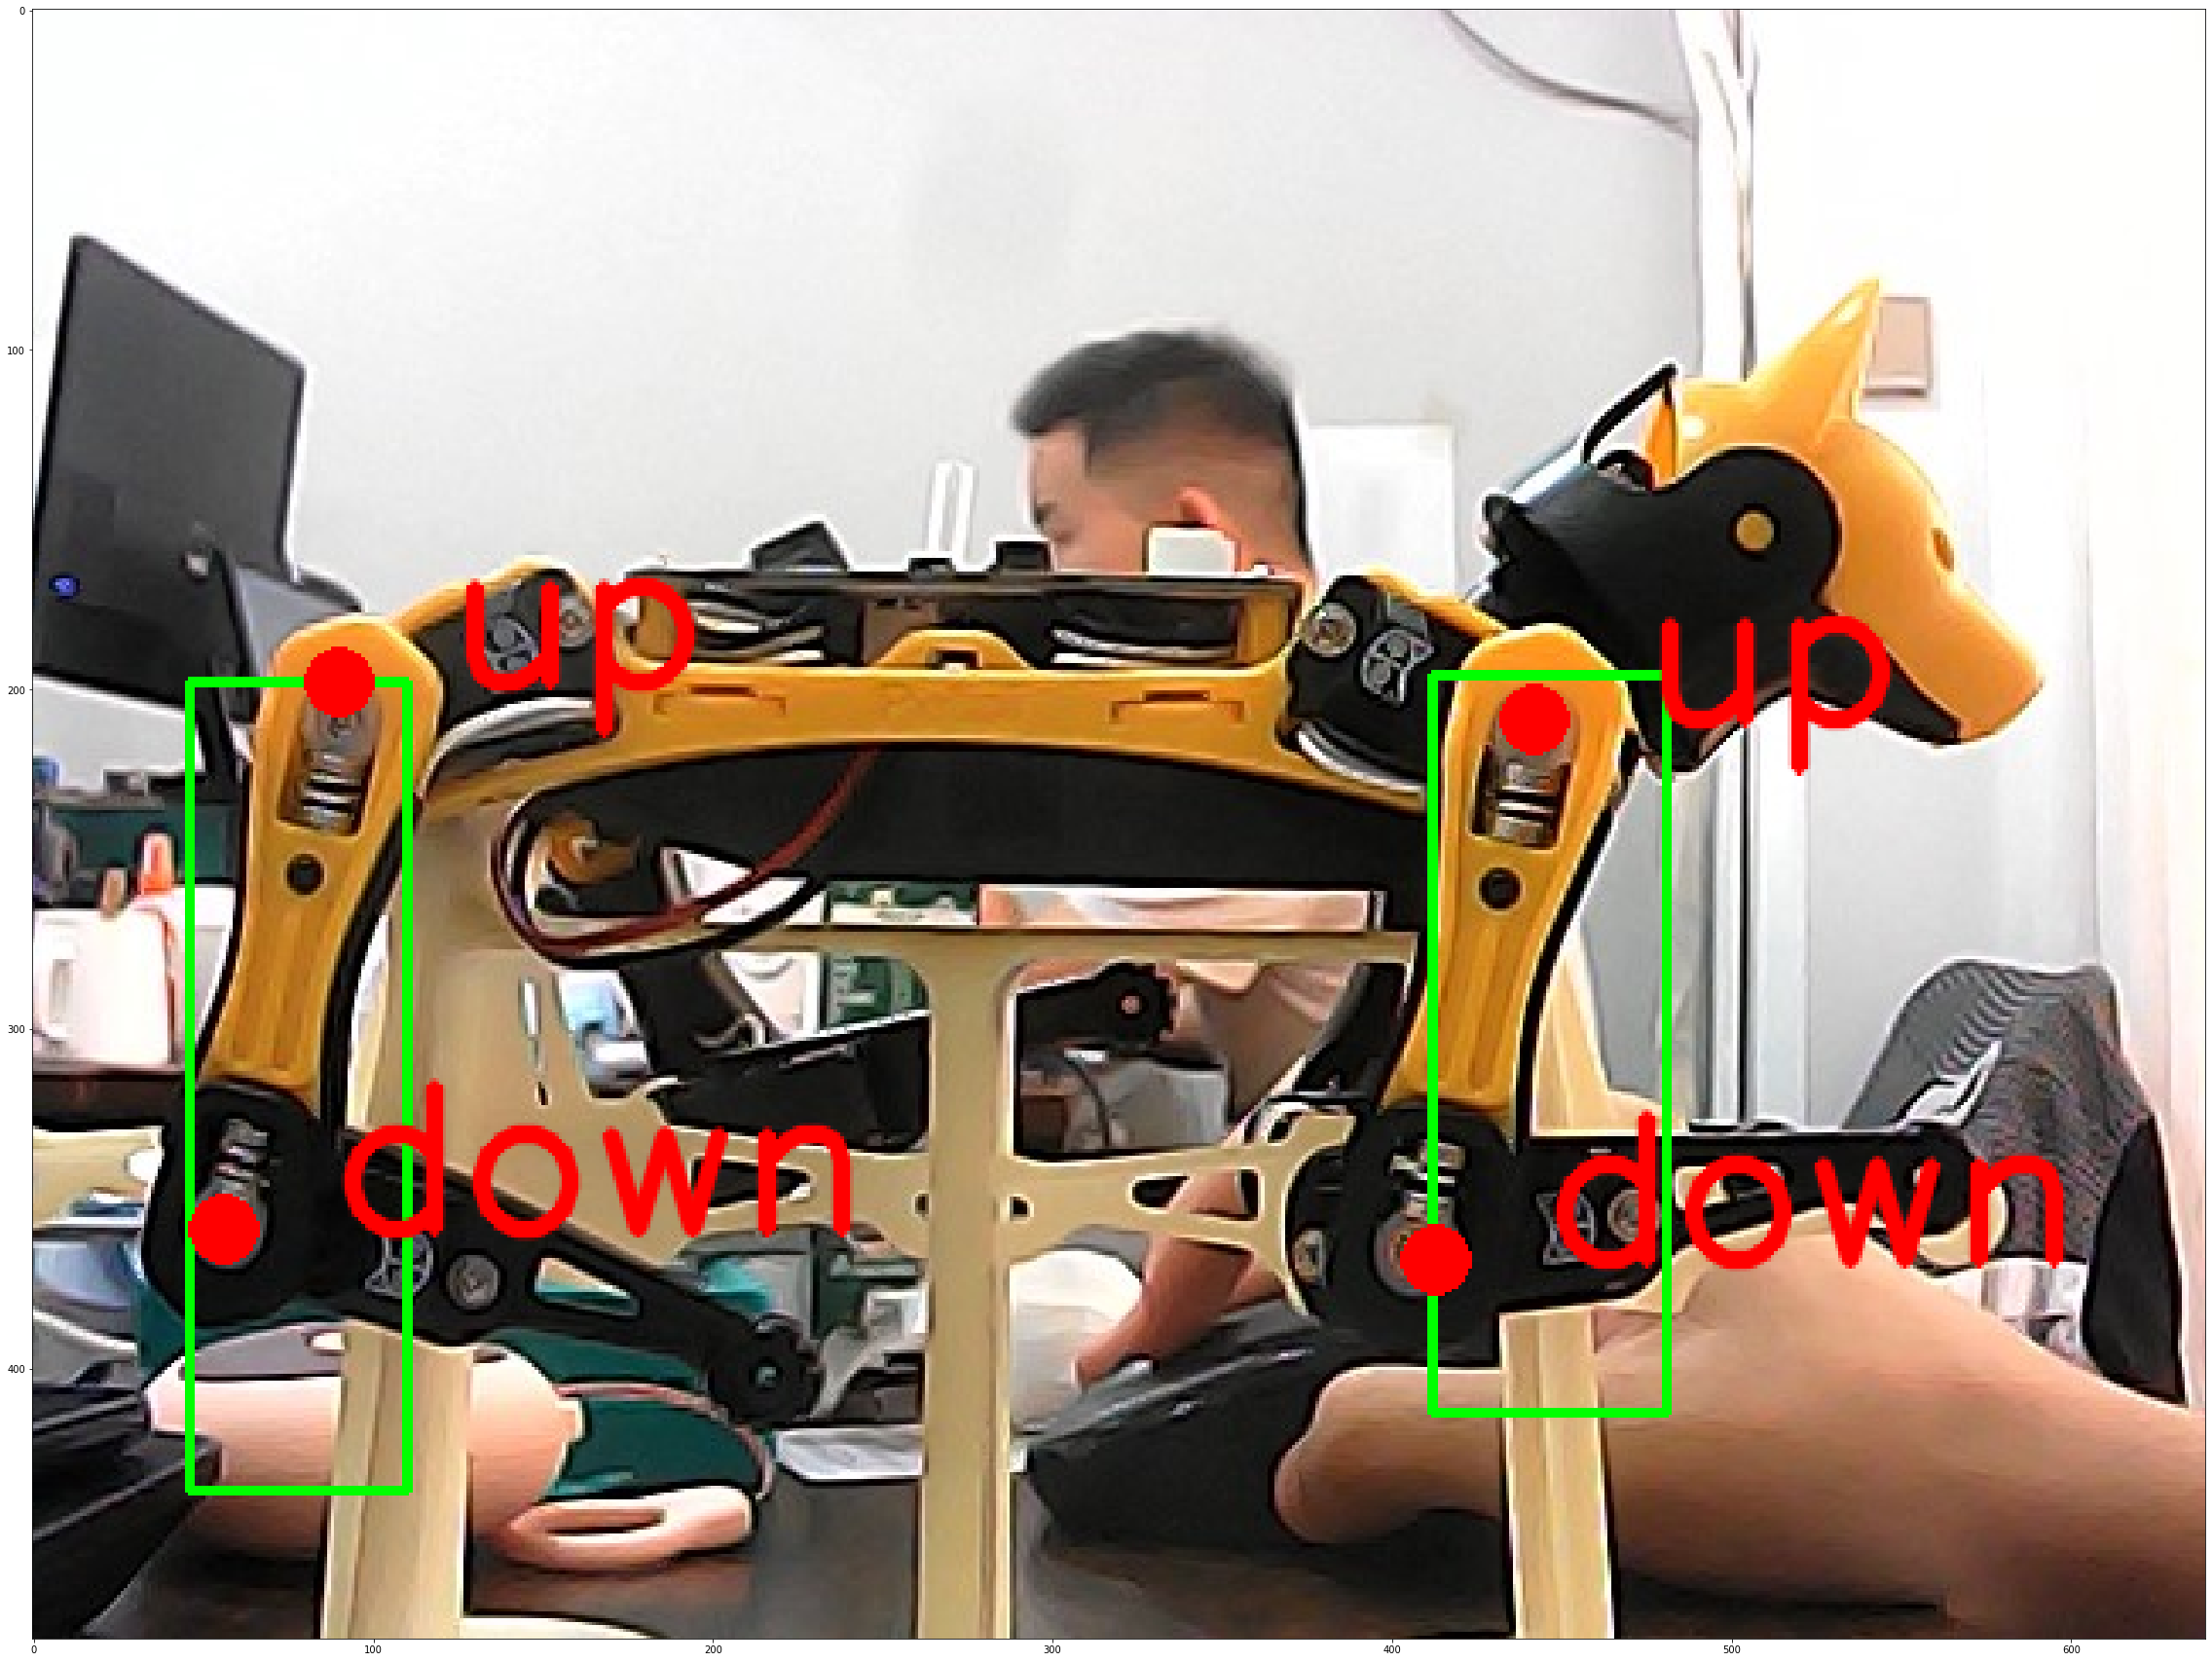

In [56]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()
scores

high_scores_idxs = np.where(scores > 0.8)[0].tolist() # Indexes of boxes with scores > 0.7
print(high_scores_idxs)
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][[0,1]], output[0]['scores'][[0,1]], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

In [35]:
iterator = iter(data_loader_test)
print(iterator)

In [34]:
images, targets = next(iterator)
print(images)
images = list(image.to(device) for image in images)
print(images)
with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

keypoint/test/annotations/28.json
(tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.0510, 0.0510, 0.0510,  ..., 0.2549, 0.2588, 0.2588],
         [0.0510, 0.0510, 0.0471,  ..., 0.2510, 0.2510, 0.2510],
         [0.0549, 0.0471, 0.0392,  ..., 0.2353, 0.2431, 0.2431]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.0549, 0.0549, 0.0588,  ..., 0.1569, 0.1608, 0.1608],
         [0.0549, 0.0549, 0.0549,  ..., 0.1569, 0.1569, 0.1569],
         [0.0588, 0.0510, 0.0471,  ..., 0.1529, 0.1490, 0.1490]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
         [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
         [0.9961, 0.996

[0, 1, 2, 3, 4]


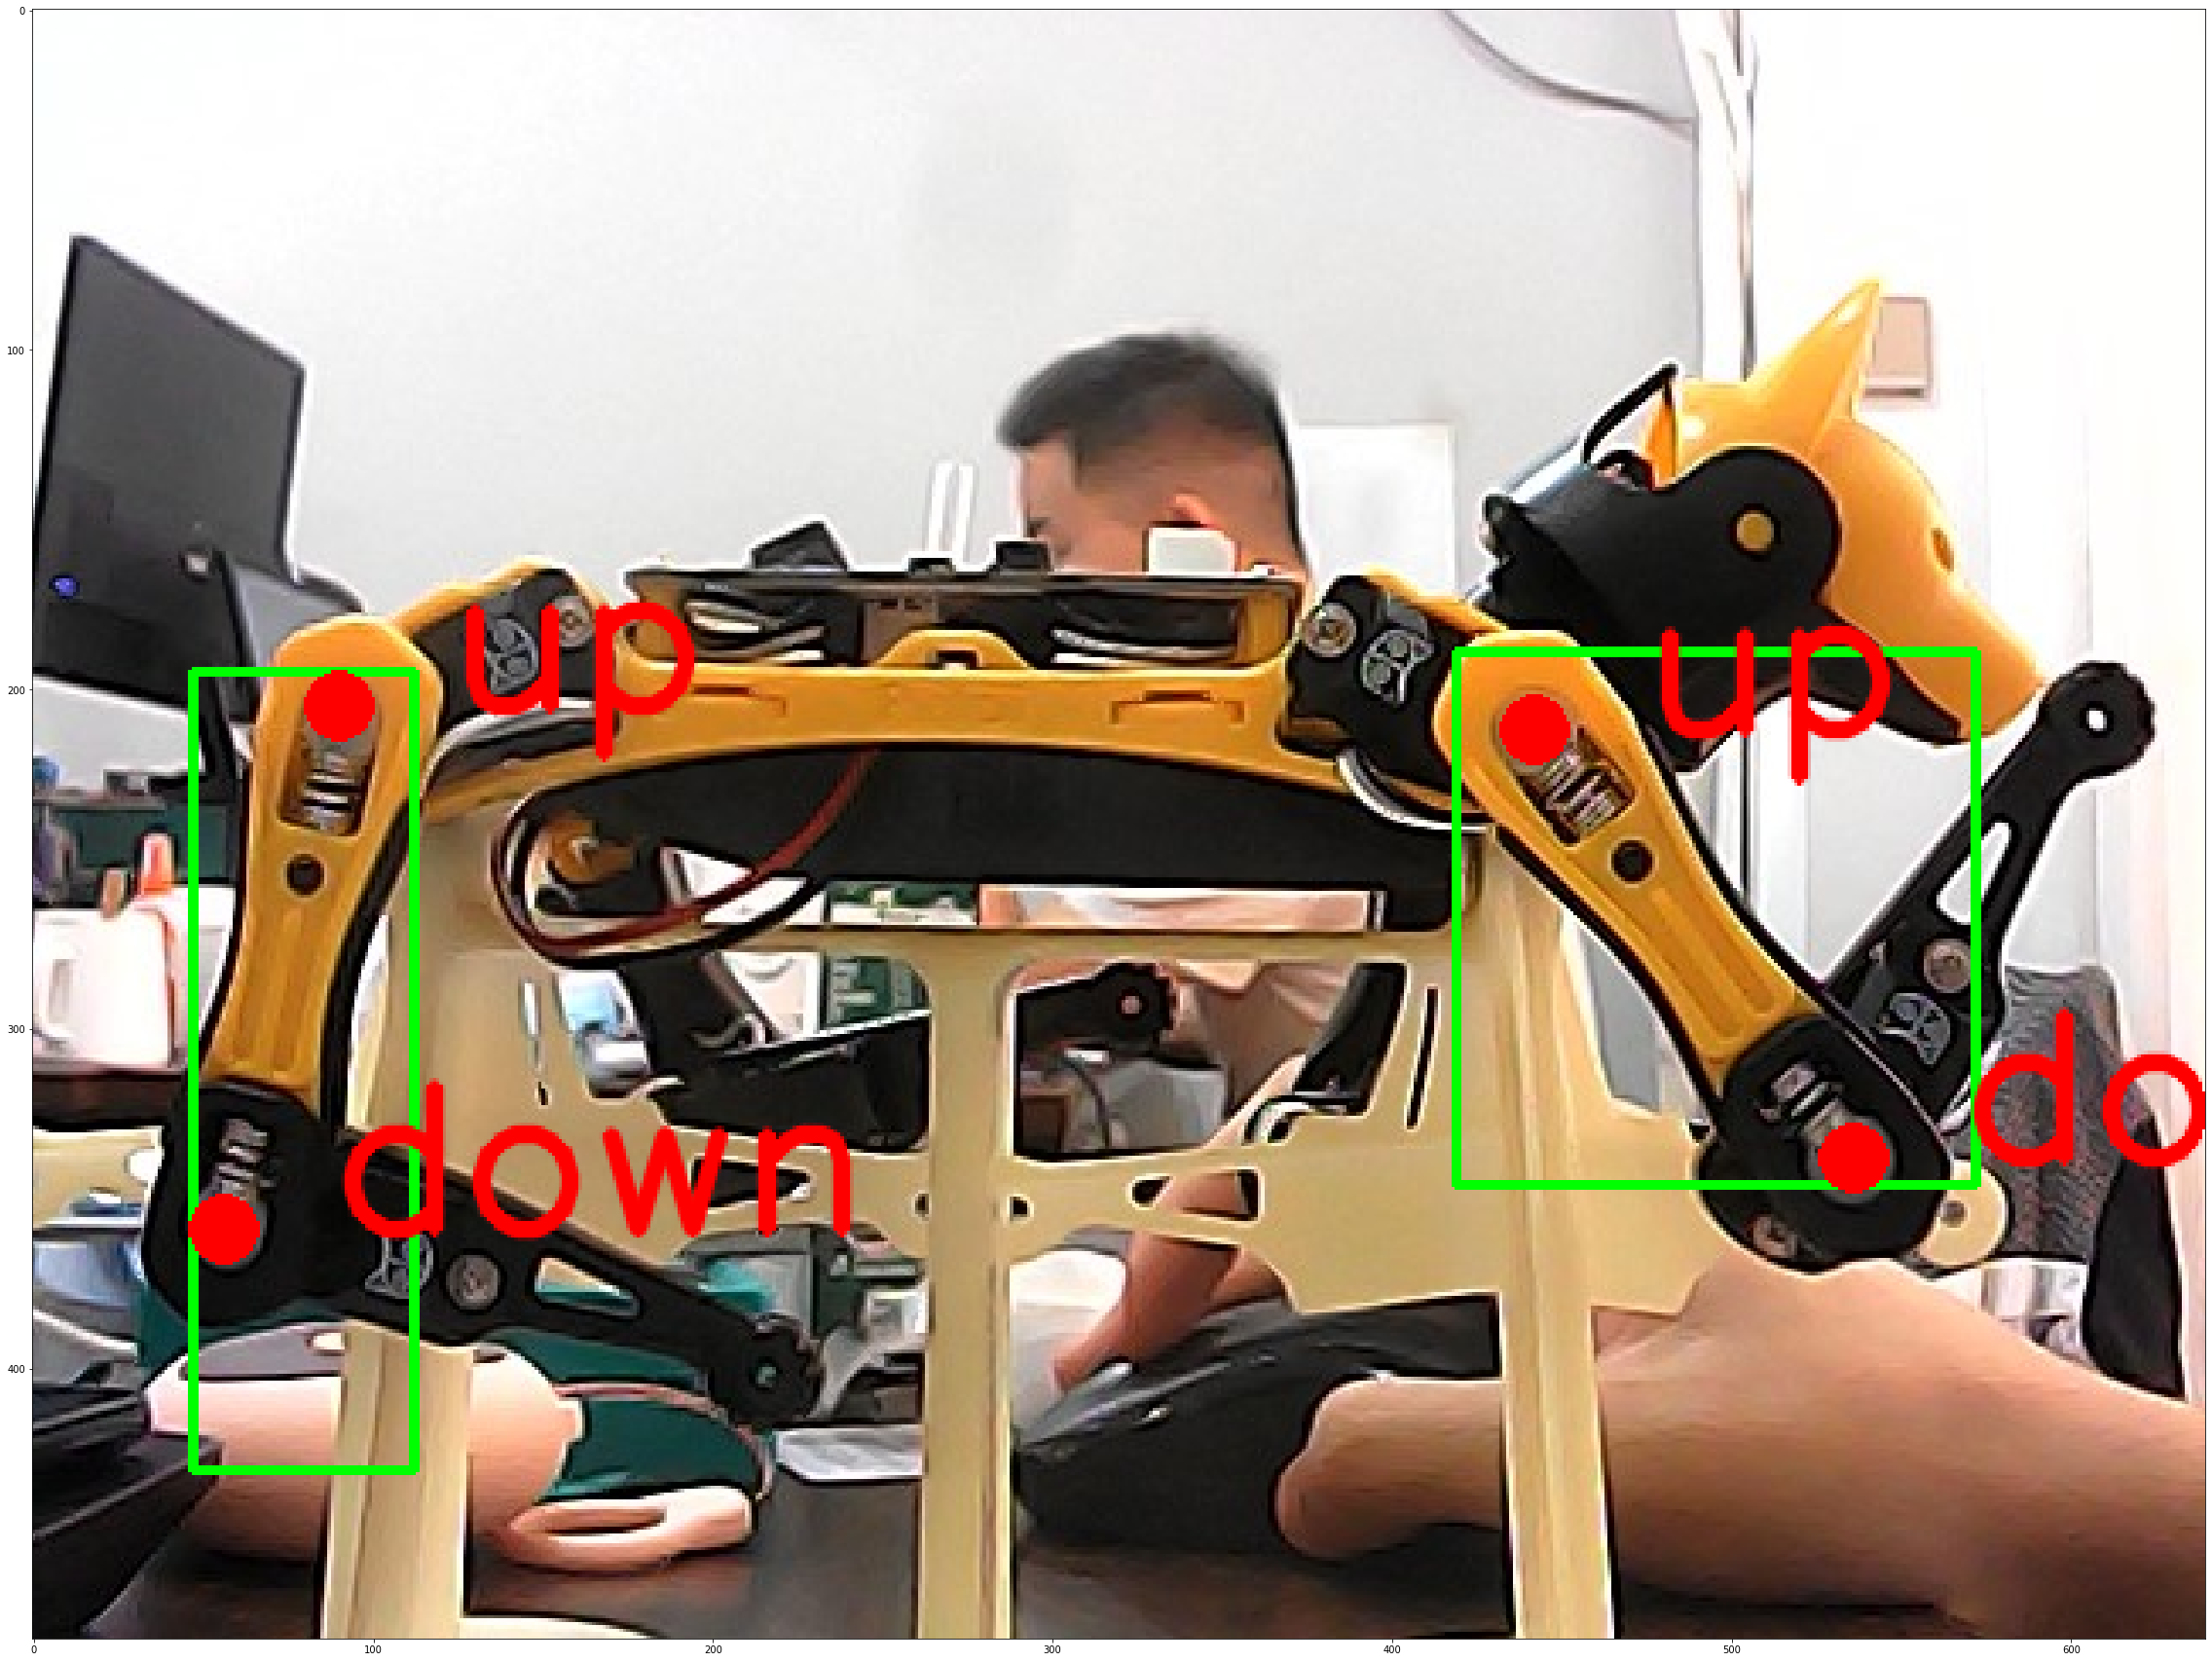

In [31]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()
scores

high_scores_idxs = np.where(scores > 0.8)[0].tolist() # Indexes of boxes with scores > 0.7
print(high_scores_idxs)
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][[0,1]], output[0]['scores'][[0,1]], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)